In [1]:
import sys
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sys.path += ["../src"]
import causal_model
from matplotlib.pyplot import subplots as sbp
from importlib import reload
from glob import glob
import climact_utils as cu
from causal_model import convert_pd_jnp_array, rotate_beta_opinions

In [2]:
import os
from tqdm import tqdm

In [4]:
path_to_data = "/data/shared/xxx/climact/experiments/"

In [5]:
# subreddit_class = "activism"

# betas_dict = {}
# for i,var_opinions in enumerate(np.append(10e-9, np.logspace(-3, 2, 6))):
#     var_opinions = round(var_opinions, 10)
#     guide, svi_results, betas = causal_model.full_experiment(subreddit_class, 1000, 0.01, var_opinions = var_opinions, 
#                                                              multivariate = True, date = "240925", progress_bar = True, id = f"20{i}", print_loss = False, save = True, return_res = True)
#     betas_dict[var_opinions] = betas

In [70]:
# id = f"{var_opinions:02d}_{init_scale:02d}_{init_scale_opinions:03d}_{lr}"

# exp_name = "activism_240927_*_*_*."
exp_name = "activism_var*_*_241009_*_*"
len(sorted(glob(causal_model.path_to_exp + f"/*{exp_name}*")))

73

In [72]:
model_settings_dict = {file: pd.read_pickle(file)["model_settings"] for file in sorted(glob(causal_model.path_to_exp + f"/*{exp_name}*"))}

In [55]:
best_files = list(pd.DataFrame([(u, model_settings_dict[u]["var_opinions"], model_settings_dict[u]["accuracy_mean"]) for u in model_settings_dict], columns = ["file", "var_opinions", "accuracy_mean"]).sort_values("accuracy_mean", ascending = False).groupby("var_opinions").first()["file"])

In [73]:
def rotate_dict_params(d):
    if d["beta_opinion_to_activation_auto_loc"] < 0:
        for v in [u for u in d if ("opinion" in u)&("loc" in u)]:
            d[v] = d[v] * (-1)
    return d


In [74]:
pickles_best = {u: pd.read_pickle(u) for u in best_files}

In [75]:
betas_dict = {str(model_settings_dict[u]["var_opinions"]) + "_" + str(model_settings_dict[u]["key"]): pd.read_pickle(u)["betas"] for u in best_files}
params_dict = {str(model_settings_dict[u]["var_opinions"]) + "_" + str(model_settings_dict[u]["key"]): pd.read_pickle(u)["params"] for u in best_files}

len_vars = len(betas_dict.keys())

betas_dict = {u: {k: convert_pd_jnp_array(betas_dict[u][k]) for k in betas_dict[u]} for u in betas_dict}
best_keys = list(betas_dict.keys())

len_single = len(sorted(betas_dict.keys()) )
single_keys = [sorted(betas_dict.keys()) [(u - 1) % len_single] for u in range(len_single)]
# single_keys = [u for u in sorted(betas_dict.keys()) if "_40" in u]
all_vars = [u.split("_")[0] for u in single_keys]

#### Histograms Opinions

In [37]:
selected_var_opinion = ["0.01", "1.0", "100.0"]


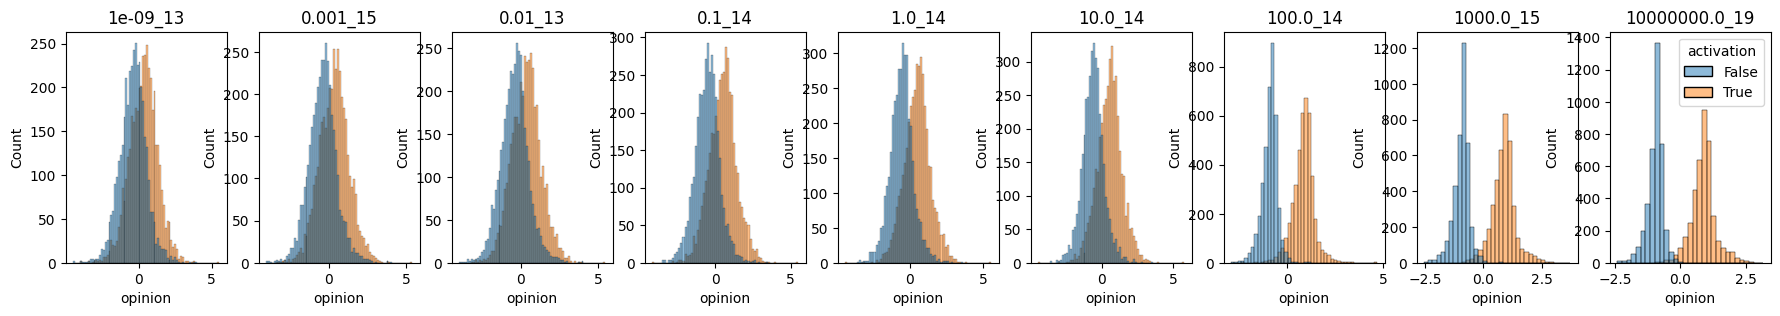

In [16]:
fig, axes = sbp(ncols = len_single, figsize = (22, 3))

for i, v in enumerate(single_keys):
    sns.histplot(data = pd.DataFrame({"opinion": betas_dict[v]["opinions_users"], "activation": betas_dict[v]["activation"]}),
                 x = "opinion", hue = "activation", ax = axes[i])
    axes[i].set_title(v)
    if i < (len_single - 1):
        axes[i].get_legend().remove()

In [43]:
mypalettehist = ["peru", "mediumaquamarine"]

[(0.01, 0.6026469469070435), (1.0, 0.6152310371398926), (100.0, 0.771217942237854)]


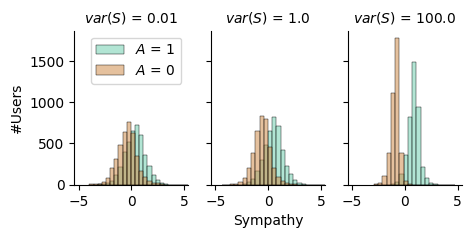

In [44]:
fig, axes = sbp(ncols = len(selected_var_opinion), figsize = (5, 2), sharey = True, sharex = True)

print([(model_settings_dict[u]["var_opinions"], model_settings_dict[u]["accuracy_mean"]) for u in best_files if str(model_settings_dict[u]["var_opinions"]) in selected_var_opinion])

for i, v in enumerate([u for u in single_keys if u.split("_")[0] in selected_var_opinion]):
    
    var_opinion = v.split("_")[0]
    
    sns.histplot(data = pd.DataFrame({"opinion": betas_dict[v]["opinions_users"], "activation": betas_dict[v]["activation"]}),
                x = "opinion", hue = "activation", ax = axes[i], binwidth = 0.4, palette = mypalettehist)
    
    
    axes[i].set_title("$var(S)$ = " + var_opinion, fontsize = 10)
    axes[i].set_ylabel("#Users")
    
    axes[i].set_xlim(-5.4,5.4)
    axes[i].spines['right'].set_visible(False)
    axes[i].spines['top'].set_visible(False)

    

    # if i == 0:
    if i == 0:
        # axes[i].legend(["$A$ = 1", "$A$ = 0"], bbox_to_anchor = (.9, 1.))
        axes[i].legend(["$A$ = 1", "$A$ = 0"],)
    else:
        axes[i].get_legend().remove()
axes[0].set_xlabel("")
axes[1].set_xlabel("Sympathy")
axes[2].set_xlabel("")
    
fig.show()
fig.savefig(f"../paper/hist_sympathy_activation.pdf", format = "pdf", bbox_inches = "tight")


    

#### Loss and Accuracies

In [24]:
df_accuracies = pd.DataFrame([(model_settings_dict[u]["var_opinions"], model_settings_dict[u]["key"], model_settings_dict[u]["accuracy_mean"], model_settings_dict[u]["accuracy_std"]) for u in best_files], columns = ["var", "key", "accuracy", "std"]).assign(lower = lambda x: x["accuracy"] - x["std"], upper = lambda x: x["accuracy"] + x["std"])
df_loss = pd.DataFrame([(model_settings_dict[u]["var_opinions"], model_settings_dict[u]["loss"]) for u in best_files], columns = ["var", "loss"])

In [25]:
df_accuracies

,var,key,accuracy,std,lower,upper
0,1.000000e-09,13,0.599552,0.006248,0.593303,0.605800
1,1.000000e-03,15,0.602899,0.006316,0.596583,0.609215
2,1.000000e-02,13,0.602647,0.006091,0.596556,0.608738
3,1.000000e-01,14,0.615134,0.006068,0.609067,0.621202
4,1.000000e+00,14,0.615231,0.006195,0.609036,0.621426
5,1.000000e+01,14,0.622667,0.006191,0.616476,0.628858
6,1.000000e+02,14,0.771218,0.005289,0.765929,0.776507
7,1.000000e+03,15,0.823522,0.004457,0.819065,0.827979
8,1.000000e+07,19,0.849898,0.003946,0.845952,0.853844


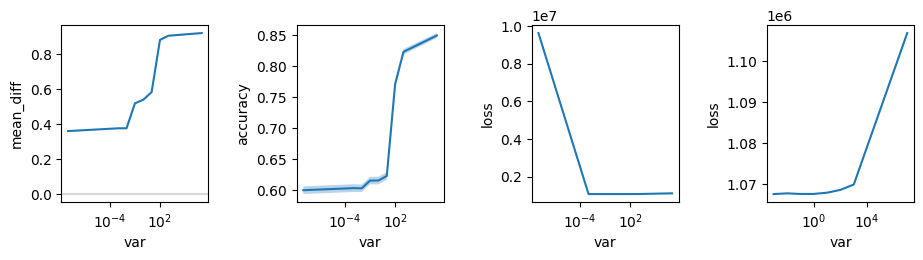

In [26]:
fig, axes = sbp(ncols = 4, figsize = (11, 2.3))
fig.subplots_adjust(wspace = 0.6)

sns.lineplot(data = pd.DataFrame([(float(v.split("_")[0]),(betas_dict[v]["opinions_users"] * betas_dict[v]["activation"]).mean() - ((betas_dict[v]["opinions_users"] * (1 - betas_dict[v]["activation"])).mean())) for v in betas_dict.keys()], columns = ["var", "mean_diff"]), x = "var", y = "mean_diff", ax = axes[0])
axes[0].set_xscale("log")
axes[0].axhline(y = 0, c = "grey", alpha = 0.3)

sns.lineplot(data = df_accuracies, x = "var", y = "accuracy", ax = axes[1])
axes[1].fill_between(x = df_accuracies["var"], y1 = df_accuracies["lower"], y2 = df_accuracies["upper"], alpha = 0.3)
axes[1].set_xscale("log")


sns.lineplot(data = df_loss, x = "var", y = "loss", ax = axes[2])
axes[2].set_xscale("log")

sns.lineplot(data = df_loss.query("var > 0.00001"), x = "var", y = "loss", ax = axes[3])
axes[3].set_xscale("log")

#### Comparison variables (scatterplots and heatmap)

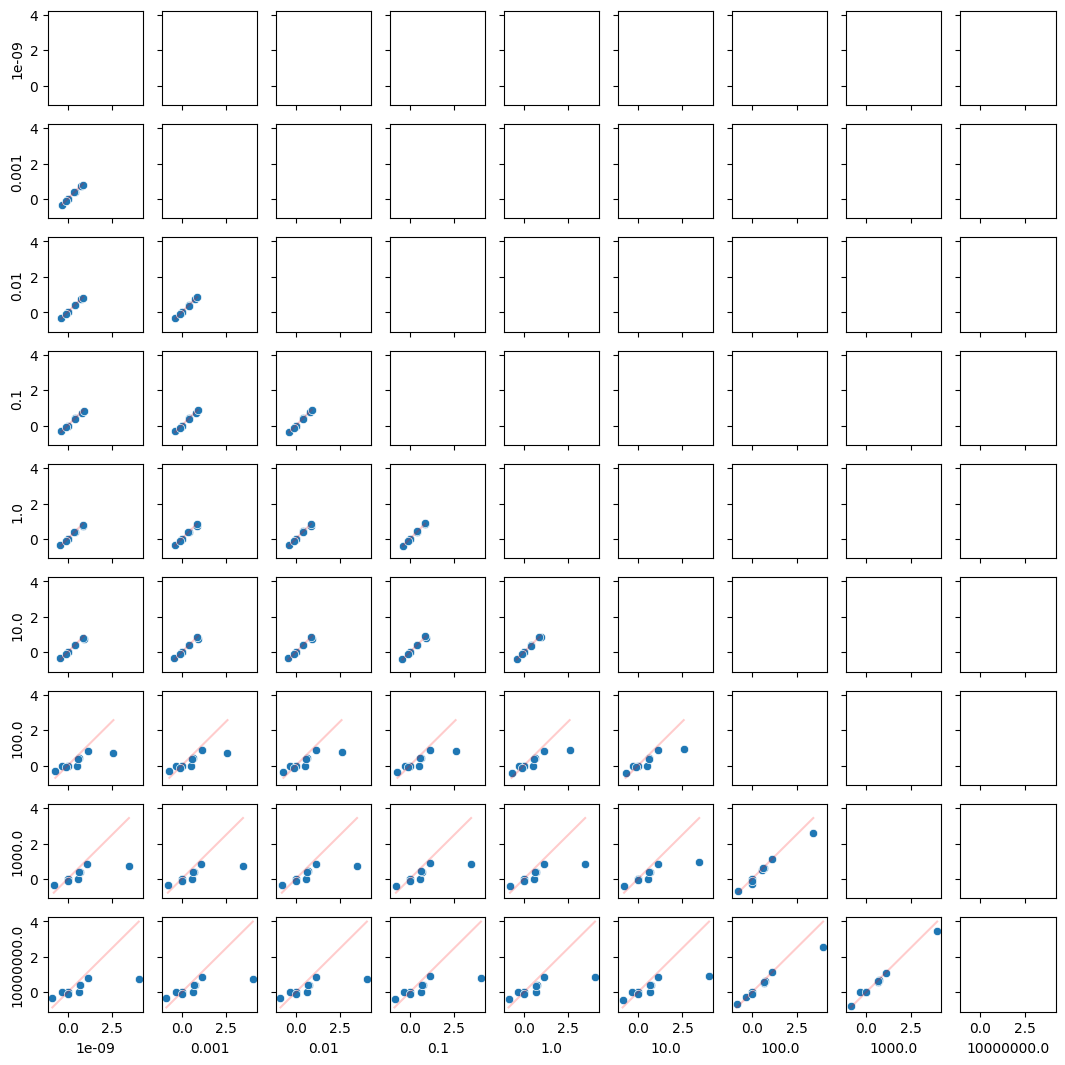

In [27]:
fig, axes = sbp(ncols = len_single, nrows = len_single, figsize = (13,13), sharex = True, sharey = True)

for i, u2 in enumerate(single_keys):
    for j, u1 in enumerate(single_keys):  
        if j < i:      
            k = "beta_to_activation"

            m1, m2 = betas_dict[u2][k].min(), betas_dict[u2][k].max()
            axes[i,j].plot(np.array([m1, m2]), np.array([m1, m2]), c = "red", alpha = 0.2)

            sns.scatterplot(y = betas_dict[u1][k], 
                            x = betas_dict[u2][k], ax = axes[i,j])
    axes[i,0].set_ylabel(u2.split("_")[0])
    axes[len_single - 1,i].set_xlabel(u2.split("_")[0])




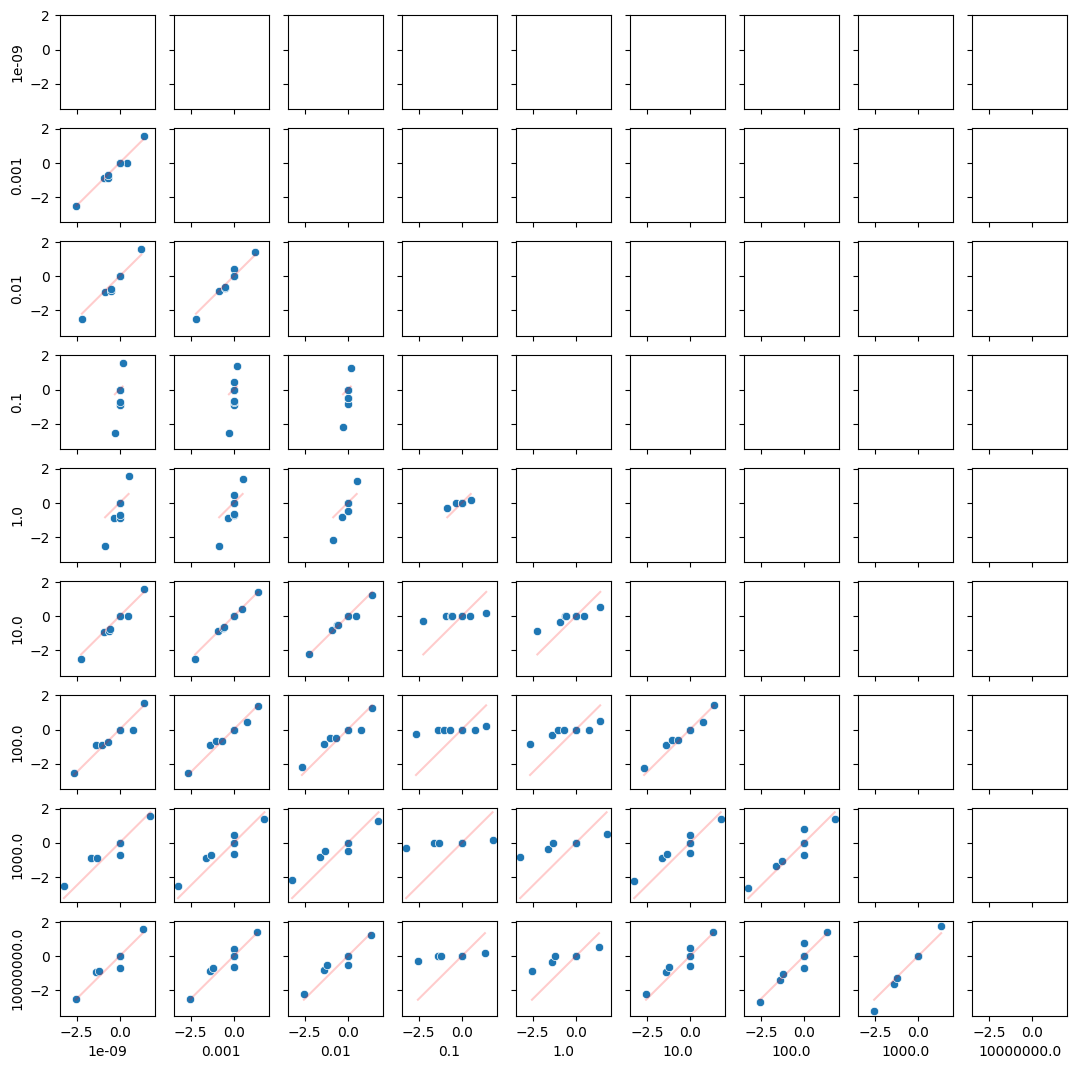

In [28]:
fig, axes = sbp(ncols = len_single, nrows = len_single, figsize = (13,13), sharex = True, sharey = True)

for i, u2 in enumerate(single_keys):
    for j, u1 in enumerate(single_keys):
        if j < i:
            k = "beta_to_opinions"

            m1, m2 = betas_dict[u2][k].min(), betas_dict[u2][k].max()
            axes[i,j].plot(np.array([m1, m2]), np.array([m1, m2]), c = "red", alpha = 0.2)

            sns.scatterplot(y = betas_dict[u1][k], 
                            x = betas_dict[u2][k], ax = axes[i,j])
    axes[i,0].set_ylabel(u2.split("_")[0])
    axes[len_single - 1,i].set_xlabel(u2.split("_")[0])



<Axes: >

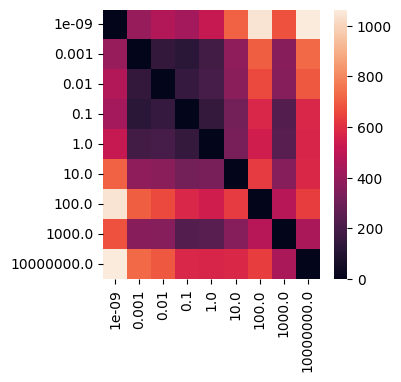

In [29]:
fig, axes = sbp(figsize = (3.5,3.5))
sns.heatmap(pd.DataFrame(np.array([((betas_dict[i]["sociodemo_users"].stack() - betas_dict[j]["sociodemo_users"].stack()) ** 2).sum() for i in single_keys for j in single_keys]).reshape(len_single, len_single), 
                         index = all_vars, columns = all_vars))




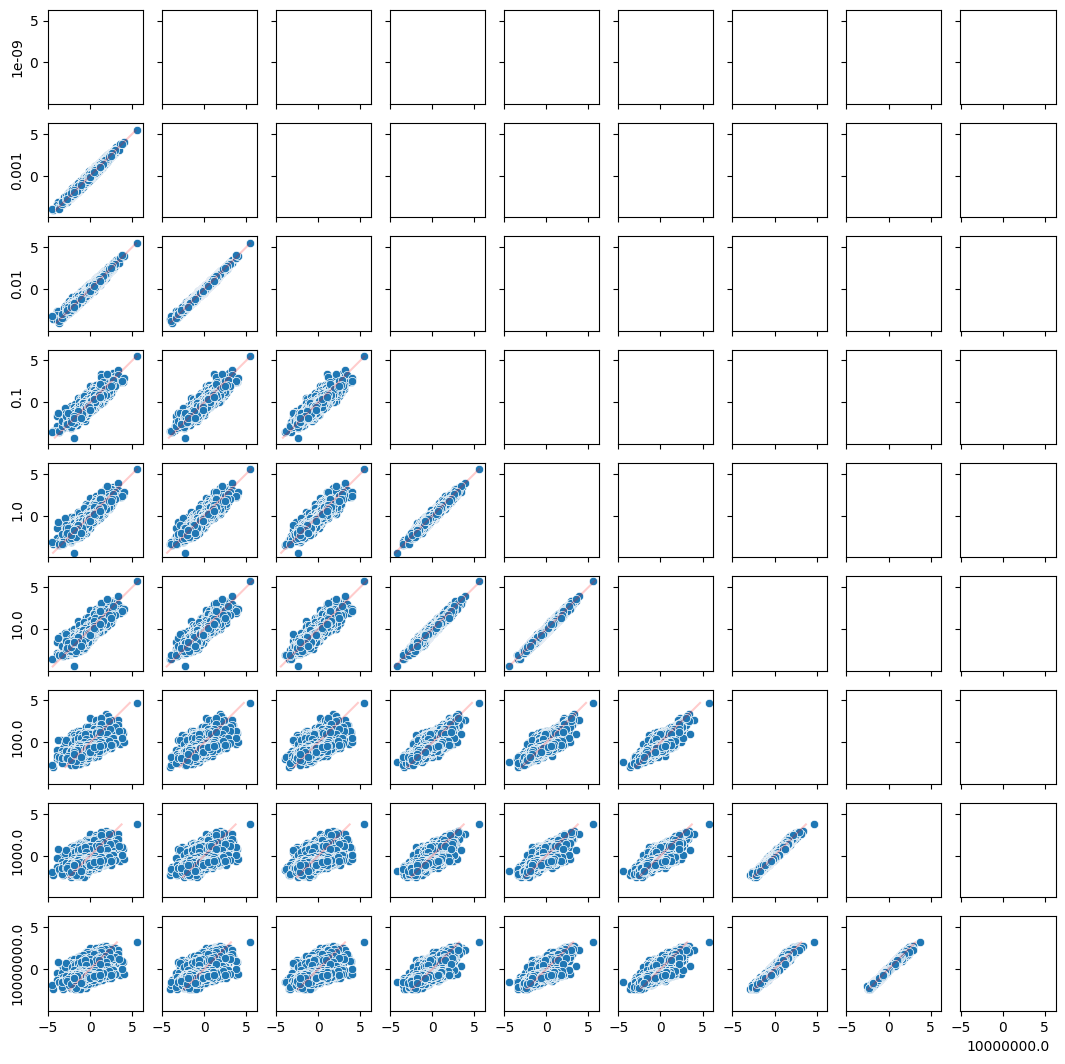

In [30]:
fig, axes = sbp(ncols = len_single, nrows = len_single, figsize = (13,13), sharex = True, sharey = True)

for i, u1 in enumerate(single_keys):
    for j, u2 in enumerate(single_keys):
        if j < i:            
            opinions_u1,opinions_u2 = betas_dict[u1]["opinions_users"],betas_dict[u2]["opinions_users"]
            opinions_u1,opinions_u2 = (opinions_u1 - opinions_u1.mean()) / opinions_u1.std(),(opinions_u2 - opinions_u2.mean()) / opinions_u2.std()
            m1, m2 = opinions_u1.min(), opinions_u1.max()
            axes[i,j].plot(np.array([m1, m2]), np.array([m1, m2]), c = "red", alpha = 0.2)

            sns.scatterplot(y = opinions_u1, 
                            x = opinions_u2, ax = axes[i,j])
            
            axes[i,j].set_ylabel("")
            axes[i,j].set_xlabel("")
    axes[i,0].set_ylabel(u1.split("_")[0])
    axes[len_single - 1,i].set_xlabel(u1.split("_")[0])



In [31]:
from numpyro import distributions
from causal_model import PRNGKey
import jax.numpy as jnp

In [32]:
def sample_params(params_dict, key, to_var, n_samples = 1000):
    loc_vars = [u for u in params_dict[key] if (to_var in u)&("loc" in u)]
    scale_vars = [u for u in params_dict[key] if (to_var in u)&("scale" in u)]
    locs, scales = [params_dict[key][loc_vars[u]] for u in range(len(loc_vars))], [params_dict[key][scale_vars[u]] for u in range(len(loc_vars))]
    dist = [distributions.Normal(locs[u], scales[u]) if np.prod(locs[u].shape) == 1 else distributions.MultivariateNormal(locs[u], scales[u]) for u in range(len(loc_vars))]
    samples = {loc_vars[u].replace("auto_loc", "loc").replace("_loc", "_samples"): np.array(dist[u].sample(PRNGKey(100), (n_samples,))) for u in range(len(loc_vars))}
    return samples


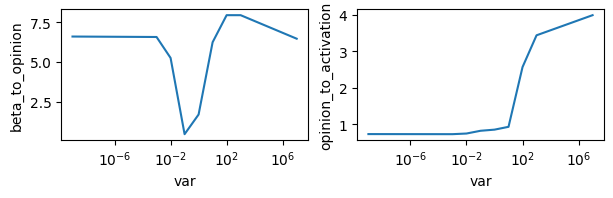

In [33]:
fig, axes = sbp(ncols = 2, figsize = (7,1.7))

sns.lineplot(data = pd.DataFrame([(float(u.split("_")[0]), np.abs(betas_dict[u]["beta_to_opinions"]).sum().item()) for u in betas_dict], columns = ["var", "beta_to_opinion"]), x = "var", y = "beta_to_opinion", ax = axes[0])
sns.lineplot(data = pd.DataFrame([(float(u.split("_")[0]), np.abs(betas_dict[u]["beta_to_activation"])["opinion"].item()) for u in betas_dict], columns = ["var", "opinion_to_activation"]), x = "var", y = "opinion_to_activation", ax = axes[1])
axes[0].set_xscale("log")
axes[1].set_xscale("log")

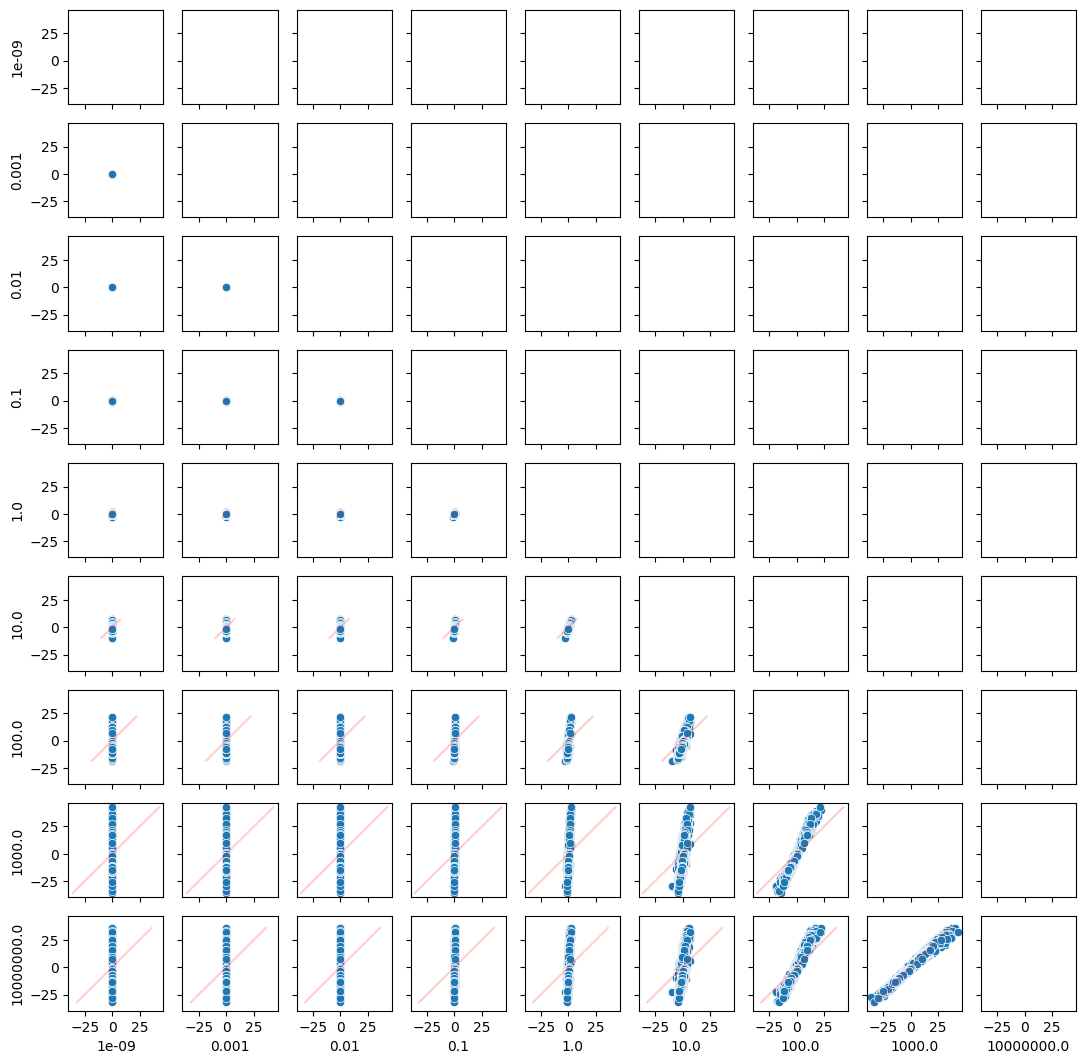

In [34]:
fig, axes = sbp(ncols = len_single, nrows = len_single, figsize = (13,13), sharex = True, sharey = True)

for i, u1 in enumerate(single_keys):
    for j, u2 in enumerate(single_keys):
        if j < i:            
            opinions_u1,opinions_u2 = params_dict[u1]["opinions_noise_auto_loc"],params_dict[u2]["opinions_noise_auto_loc"]
            
            m1, m2 = opinions_u1.min(), opinions_u1.max()
            axes[i,j].plot(np.array([m1, m2]), np.array([m1, m2]), c = "red", alpha = 0.2)

            sns.scatterplot(y = opinions_u1, 
                            x = opinions_u2, ax = axes[i,j])
    axes[i,0].set_ylabel(u1.split("_")[0])
    axes[len_single - 1,i].set_xlabel(u1.split("_")[0])

            



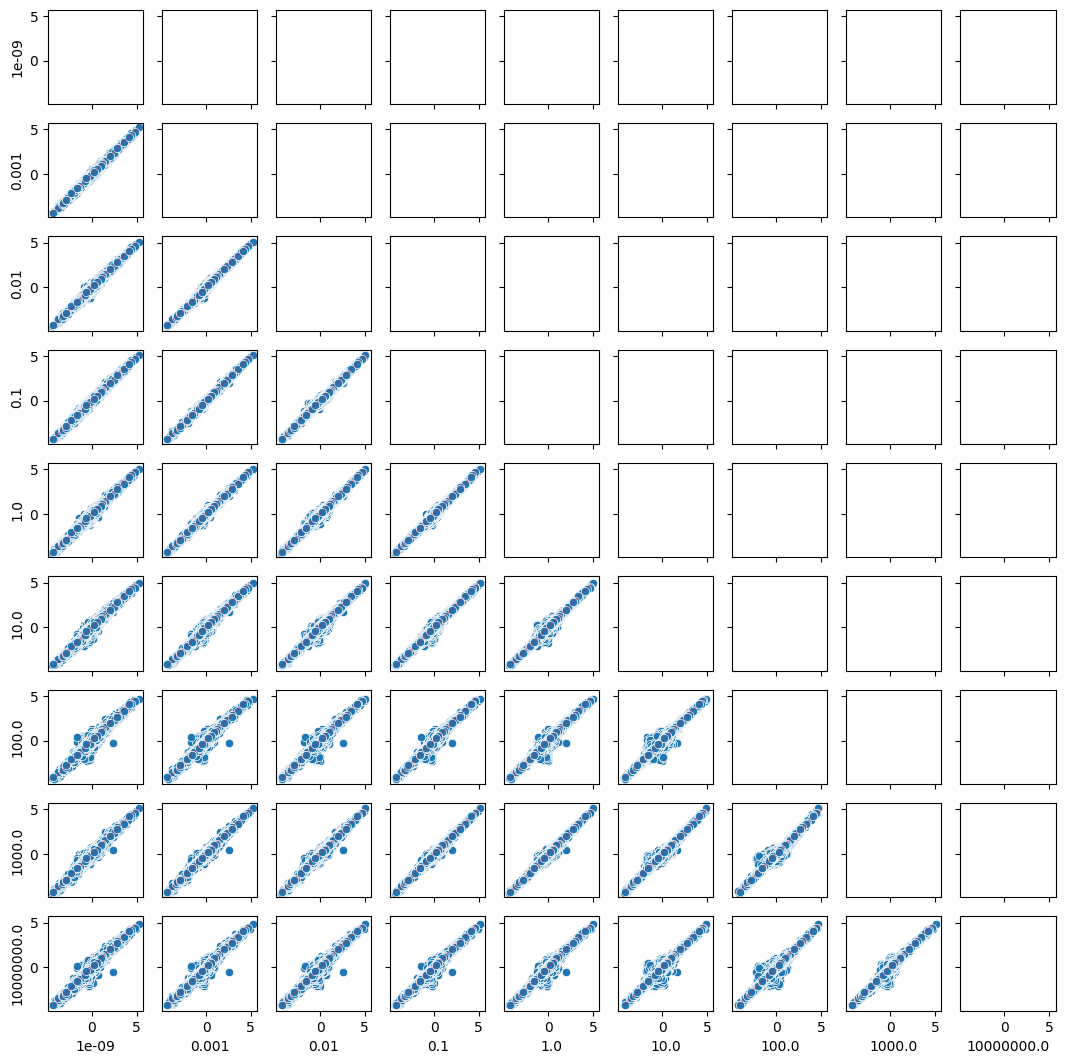

In [35]:
fig, axes = sbp(ncols = len_single, nrows = len_single, figsize = (13,13), sharex = True, sharey = True)


for i, u1 in enumerate(single_keys):
    for j, u2 in enumerate(single_keys):
        if j < i:            
            
            sociodemo_u1 = np.array(betas_dict[u1]["sociodemo_users"]).reshape(len(betas_dict[u1]["sociodemo_users"])*4)
            sociodemo_u2 = np.array(betas_dict[u2]["sociodemo_users"]).reshape(len(betas_dict[u2]["sociodemo_users"])*4)
            
            m1, m2 = sociodemo_u1.min(), sociodemo_u1.max()
            axes[i,j].plot(np.array([m1, m2]), np.array([m1, m2]), c = "red", alpha = 0.2)

            sns.scatterplot(y = sociodemo_u1, 
                            x = sociodemo_u2, ax = axes[i,j])
    axes[i,0].set_ylabel(u1.split("_")[0])
    axes[len_single - 1,i].set_xlabel(u1.split("_")[0])



#### errorplot

In [61]:
data_exp = pd.DataFrame([causal_model.get_experiments_data(pd.read_pickle(file)) for file in best_files])

In [62]:
from numpyro import distributions
from causal_model import PRNGKey

In [63]:
interesting_coefs_loc_names = ["beta_sociodemo_to_opinions_loc", "beta_news_to_opinions_loc", 
                               "beta_sociodemo_to_interaction_auto_loc", 
                              #  "beta_sociodemo_to_interaction_loc", 
                               "beta_opinion_to_activation_auto_loc", 
                               "beta_interaction_to_activation_auto_loc", 
                               "beta_news_LT_to_activation_loc", 
                               "beta_news_ST_to_activation_loc", 
                               "beta_sociodemo_to_sub_ST_loc",
                               "beta_retention_to_sub_ST_auto_loc"]
coefs_index = ["age_to_opinion", "gender_to_opinion", "partisan_to_opinion",  "affluence_to_opinion", 
               "climate_LT_to_opinion", "climate_action_LT_to_opinion", "natural_disaster_LT_to_opinion", 
               "age_to_interaction", "gender_to_interaction", "partisan_to_interaction",  "affluence_to_interaction", 
               "opinion_to_activation", "interaction_to_activation", "climate_LT_to_activation", "climate_action_LT_to_activation", "natural_disaster_LT_to_activation",
                "climate_ST_to_activation", "climate_action_ST_to_activation", "natural_disaster_ST_to_activation",
                "age_to_sub_ST", "gender_to_sub_ST", "partisan_to_sub_ST",  "affluence_to_sub_ST", "retention_to_sub_ST"]
interesting_coefs_scale_names = [u.replace("auto_loc", "auto_scale").replace("_loc", "_scale_tril") for u in interesting_coefs_loc_names]

In [64]:
def return_percentiles(params_dict, key, coefs_loc_name, coefs_scale_name,  perc1 = 5, perc2 = 95):
    if "tril" in coefs_scale_name:
        samples = distributions.MultivariateNormal(params_dict[key][coefs_loc_name], params_dict[key][coefs_scale_name]).sample(PRNGKey(10), (10000,))
    else:
        samples = distributions.Normal(params_dict[key][coefs_loc_name], params_dict[key][coefs_scale_name]).sample(PRNGKey(10), (10000,))
    return np.percentile(samples, perc1, axis = 0), np.percentile(samples, perc2, axis = 0)

def get_df_mean_ci(params_dict, key, perc1 = 5, perc2 = 95, coefs_loc_names = interesting_coefs_loc_names, coefs_scale_names = interesting_coefs_scale_names, coefs_index = coefs_index):
    all_perc_one_exp = [return_percentiles(params_dict, key, coefs_loc_names[u], coefs_scale_names[u], perc1 = perc1, perc2 = perc2) for u in range(len(coefs_loc_names))]
    df = pd.DataFrame([np.concatenate([np.array(params_dict[key][u]) for u in coefs_loc_names]), (np.concatenate([u[0] for u in all_perc_one_exp])), (np.concatenate([u[1] for u in all_perc_one_exp]))], 
                              index = ["mean", "lower", "upper"], columns = coefs_index).T[-1::-1]
    return df

def rgb_to_hex(rgb):
    return '#' + ''.join(f'{int(c * 255):02x}' for c in rgb)

In [76]:
all_perc_one_exp = [return_percentiles(params_dict, best_keys[1], interesting_coefs_loc_names[u], interesting_coefs_scale_names[u], perc1 = 5, perc2 = 95) for u in range(len(interesting_coefs_loc_names))]

In [77]:
df_mean_ci_dict = {key: get_df_mean_ci(params_dict, key) for key in best_keys}
df_mean_ci = pd.concat([df_mean_ci_dict[key].assign(var_opinion = key.split("_")[0]) for key in df_mean_ci_dict])

In [78]:
# df_mean_ci.to_csv(cu.data_path + "coefficients_credible_intervals.csv")
# df_mean_ci = pd.read_csv(cu.data_path + "coefficients_credible_intervals.csv", index_col = 0)
df_mean_ci["var_opinion"] = df_mean_ci["var_opinion"].astype("str")

In [79]:
# selected_var_opinion = ["1e-09", "0.001", "0.01", "0.1", "1.0", "10.0", "100.0", "1000.0", "10000000.0"]
selected_var_opinion = ["0.01", "1.0", "100.0"]
# selected_var_opinion = ["0.001", "0.1", "10.0", "1000.0"]

In [229]:
mypalette = [sns.color_palette("muted")[k] for k in [6,0,1,9,4,8,5,2,3]][:len(selected_var_opinion)]
# mypalette = sns.color_palette("Greens")
mypalette = [sns.color_palette("YlGn")[u] for u in [1,3,5]]
mypalette = [sns.color_palette("YlGnBu")[u] for u in [0,2,4]]

In [230]:
sns.color_palette("YlGn", n_colors = 20)

[(0.9881891580161476, 0.9955709342560554, 0.8330795847750865),
 (0.9763783160322953, 0.9911418685121107, 0.7681199538638985),
 (0.9534025374855825, 0.9821453287197233, 0.7143252595155709),
 (0.9091118800461361, 0.9644290657439446, 0.6818454440599769),
 (0.8648212226066897, 0.946712802768166, 0.6493656286043828),
 (0.8009073433294887, 0.9195540176855056, 0.6153171856978085),
 (0.7359477124183007, 0.8915032679738563, 0.5843137254901961),
 (0.6694655901576317, 0.8627758554402153, 0.5533102652825836),
 (0.5912187620146098, 0.8288196847366398, 0.5223068050749712),
 (0.5129719338715879, 0.7948635140330642, 0.4913033448673587),
 (0.4266051518646674, 0.754878892733564, 0.4521184159938485),
 (0.3454056132256824, 0.7150173010380623, 0.41078046905036525),
 (0.2642060745866974, 0.6751557093425605, 0.36944252210688194),
 (0.21568627450980393, 0.6196078431372549, 0.330718954248366),
 (0.17139561707035755, 0.5620299884659746, 0.2923337178008458),
 (0.12110726643598617, 0.5047289504036909, 0.2572087658592849),
 (0.06943483275663206, 0.4633910034602076, 0.23949250288350635),
 (0.017762399077277974, 0.4220530565167243, 0.22177623990772782),
 (0.0, 0.3739331026528258, 0.20212226066897349),
 (0.0, 0.3222606689734717, 0.18145328719723186)]

In [80]:
mypalette = [sns.color_palette("YlGn", n_colors = 20)[u] for u in [6,11,16]]

In [232]:
coefs_to_var = {k: [u for u in coefs_index if f"to_{k}" in u] for k in ["opinion", "interaction", "activation", "sub_ST"]}

In [81]:
coefs_to_var = {k: [u for u in coefs_index if f"to_{k}" in u] for k in ["opinion", "sub_ST", "interaction", "activation"]}
coefs_to_var["sub_ST"].pop()

'retention_to_sub_ST'

/tmp/ipykernel_3480295/1576549930.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_yticklabels([f"$M_L$({u})" for u in ["natural disasters", "climate action", "climate"]] + [f"$D$({u})" for u in ["affluence", "partisan", "gender", "age"]])
/tmp/ipykernel_3480295/1576549930.py:66: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_yticklabels(["$D_{sub}$" + f"({u})" for u in ["affluence", "partisan", "gender", "age"]])
/tmp/ipykernel_3480295/1576549930.py:67: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[2].set_yticklabels(["$D_{sub}$" + f"({u})" for u in ["affluence", "partisan", "gender", "age"]])
/tmp/ipykernel_3480295/1576549930.py:68: UserWarning: set_ticklabels() should only be used with a fixed number of 

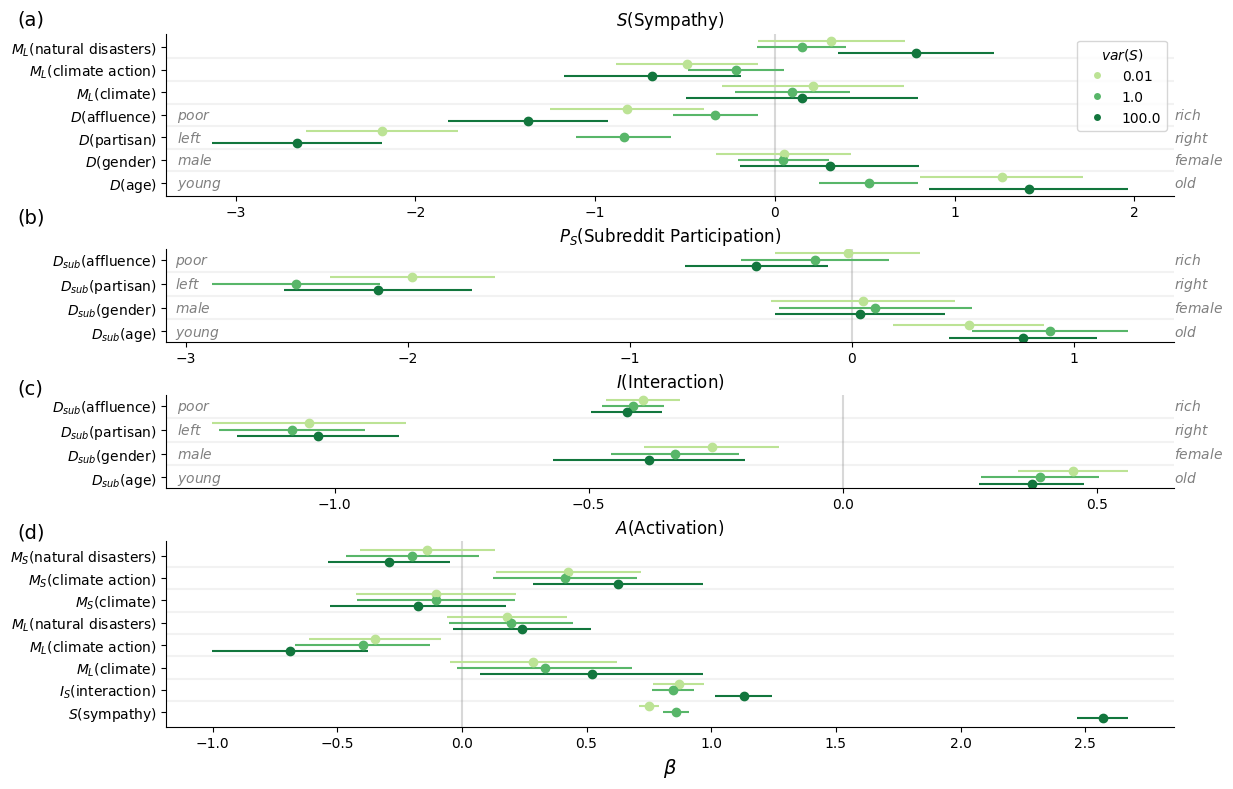

In [83]:
fig, axes = sbp(nrows = 4, figsize = (13, 9), height_ratios = [len(coefs_to_var[u]) for u in coefs_to_var])
fig.subplots_adjust(hspace = .4)
df_mean_ci = df_mean_ci.reset_index().query("index != 'retention_to_sub_ST'").set_index("index")

for j, to_var in enumerate(["opinion", "sub_ST", "interaction", "activation"]):
    selected_vars = coefs_to_var[to_var]
    df = df_mean_ci.reset_index().assign(error = lambda x: x["mean"] - x["lower"]).query("(var_opinion in @selected_var_opinion)&(index in @selected_vars)").assign(num_var_opinion = lambda x: x["var_opinion"].astype(float))
    df = df.merge(df.query(f"var_opinion == '{selected_var_opinion[0]}'").assign(sorting = lambda x: np.arange(len(x)))[["index", "sorting"]])
    
    sp = sns.stripplot(data = df, x = "mean", y = "index", 
                       hue = "var_opinion", palette = mypalette, 
                       dodge = True, jitter = False, ax = axes[j])
    for i in range(len(selected_vars) - 1):
        axes[j].axhline(i + 0.5, color = "grey", alpha = 0.1)
    xy_coordinates = np.concatenate([u.get_offsets().data for u in sp.collections]) 
    cols = mypalette
    
    axes[j].axvline(x = 0, c = "grey", alpha = 0.3)

    
    # axes[j].set_yticklabels([str(u).replace(f"_to_{to_var}", "") for u in df["index"].unique()])

    for i in range(len(df)):
        x, y = xy_coordinates[i]
        col = cols[i % len(selected_var_opinion)]
        axes[j].errorbar(x = x, y = y, 
                      xerr = df.sort_values(["sorting", "var_opinion"])["error"].iloc[i], 
                    fmt = "o", c = col)

    
    axes[j].set_ylabel("")
    axes[j].set_xlabel("")

    # axes[j].yaxis.grid(True, linewidth = 0.2)
    axes[j].yaxis.grid(False)
    axes[j].xaxis.grid(False)

    axes[j].spines['top'].set_visible(False)
    axes[j].spines['right'].set_visible(False)

    axes[j].legend(title = "$var(S)$").set_visible(j == 0)

adjy = 0.2

x1, x2 = axes[0].get_xlim()
for k, (text1, text2) in enumerate([["young", "old"], ["male", "female"], ["left", "right"], ["poor", "rich"]]):
    axes[0].text(x1 + 0.06, 6 - k + adjy, "$" + text1 + "$", ha = "left", color = "grey")
    axes[0].text(x2, 6 - k + adjy, "$" + text2 + "$", ha = "left", color = "grey")
x1, x2 = axes[1].get_xlim()
for j, (text1, text2) in enumerate([["young", "old"], ["male", "female"], ["left", "right"], ["poor", "rich"]]):
    axes[1].text(x1 + 0.04, 3 - j + adjy, "$" + text1 + "$", ha = "left", color = "grey")
    axes[1].text(x2, 3 - j + adjy, "$" + text2 + "$", ha = "left", color = "grey")
x1, x2 = axes[2].get_xlim()
for j, (text1, text2) in enumerate([["young", "old"], ["male", "female"], ["left", "right"], ["poor", "rich"]]):
    axes[2].text(x1 + 0.02, 3 - j + adjy, "$" + text1 + "$", ha = "left", color = "grey")
    axes[2].text(x2, 3 - j + adjy, "$" + text2 + "$", ha = "left", color = "grey")

axes[2].set_xticks([-1,-0.5,0,0.5])

axes[0].set_title("$S$(Sympathy)")
axes[1].set_title("$P_S$(Subreddit Participation)")
axes[2].set_title("$I$(Interaction)")
axes[3].set_title("$A$(Activation)")

axes[0].set_yticklabels([f"$M_L$({u})" for u in ["natural disasters", "climate action", "climate"]] + [f"$D$({u})" for u in ["affluence", "partisan", "gender", "age"]])
axes[1].set_yticklabels(["$D_{sub}$" + f"({u})" for u in ["affluence", "partisan", "gender", "age"]])
axes[2].set_yticklabels(["$D_{sub}$" + f"({u})" for u in ["affluence", "partisan", "gender", "age"]])
axes[3].set_yticklabels([f"$M_{p}$({u})" for p in ["S", "L"] for u in ["natural disasters", "climate action", "climate"]] + ["$I_S$(interaction)", "$S$(sympathy)"])

axes[3].set_xlabel("$\\beta$", fontsize = 14)
# axes[0].legend(title = "$var(SYM)$")#.set_visible(False)
# axes[1].legend(title = "$var(SYM)$").set_visible(False)
# axes[2].legend(title = "$var(SYM)$").set_visible(False)

plt.gcf().text(0.01, .89, "(a)", fontsize=14)
plt.gcf().text(0.01, 0.67, "(b)", fontsize=14)
plt.gcf().text(0.01, 0.48, "(c)", fontsize=14)
plt.gcf().text(0.01, 0.32, "(d)", fontsize=14)

fig.savefig(f"../paper/errorbar_coefficients_subplots.pdf", format = "pdf", bbox_inches = "tight")



#### Sociodemo

In [26]:
df_users = causal_model.load_dataframe("activism")
subreddits_geolocation = pd.read_csv(cu.data_path + "geolocated_users_window.csv", index_col = 0)
sample_df = pd.read_csv(cu.data_path + f"sample_authors/activism_sample.csv", index_col = [0,1])

In [57]:
sample_df.reset_index().assign(geolocated_user = lambda x: x["author"].isin(subreddits_geolocation["author"])).groupby(["active", "geolocated_user"]).count()["author"].unstack().apply(lambda x: x / x.sum(), axis = 1)

geolocated_user,False,True
active,,
False,0.739016,0.260984
True,0.751344,0.248656


In [58]:
df_users.reset_index().groupby("author").first().reset_index().assign(geolocated = lambda x: x["author"].isin(subreddits_geolocation["author"])).groupby("activation").mean(numeric_only = True)["geolocated"]

activation
False    0.266143
True     0.249027
Name: geolocated, dtype: float64

In [59]:
df_users.reset_index().groupby("author").first().reset_index().assign(geolocated = lambda x: x["author"].isin(subreddits_geolocation["author"])).mean(numeric_only = True)["geolocated"]

0.2559652928416486

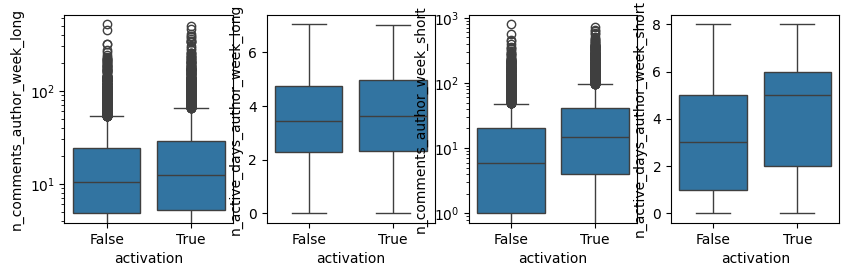

In [36]:
fig, axes = sbp(ncols = 4, figsize = (10, 2.7))

for j, var in enumerate(["n_comments_author_week_long", "n_active_days_author_week_long", "n_comments_author_week_short", "n_active_days_author_week_short"]):
    sns.boxplot(data = df_users, x = "activation", y = var, ax = axes[j])
    if j in [0,2]:
        axes[j].set_yscale("log")

In [23]:
df_sub = df_users[[u for u in df_users.columns if u[1:].replace("_long", "") in causal_model.scores.index]].rename(columns = lambda x: x[1:].replace("_long", ""))

In [24]:
data, data_obs = causal_model.get_data(df_users, causal_model.scores, remove_non_active = False)
subreddit_LT, activity_LT, log_activity_LT, news_LT, subreddit_ST, activity_ST, log_activity_ST, news_ST, interaction_ST, activation, sociodemo_subreddit, popularity_subreddits, log_popularity_subreddits, subreddit_list = data

In [25]:
sociodemo_users = pd.DataFrame(np.matrix(df_sub[causal_model.subreddit_list]) @ np.matrix(causal_model.scores.loc[causal_model.subreddit_list]), columns = cu.sociodemo_classes, index = df_users.index)

In [27]:
sociodemo_users.assign(activity_LT = log_activity_LT[:,3]).corr()

,age,gender,partisan,affluence,activity_LT
age,1.000000,0.157355,-0.038935,0.404528,0.018718
gender,0.157355,1.000000,-0.530684,0.468108,0.383508
partisan,-0.038935,-0.530684,1.000000,-0.073649,-0.216703
affluence,0.404528,0.468108,-0.073649,1.000000,0.424164
activity_LT,0.018718,0.383508,-0.216703,0.424164,1.000000


In [118]:
import matplotlib.gridspec as gridspec


class SeabornFig2Grid():

    def __init__(self, seaborngrid, fig,  subplot_spec):
        self.fig = fig
        self.sg = seaborngrid
        self.subplot = subplot_spec
        if isinstance(self.sg, sns.axisgrid.FacetGrid) or \
            isinstance(self.sg, sns.axisgrid.PairGrid):
            self._movegrid()
        elif isinstance(self.sg, sns.axisgrid.JointGrid):
            self._movejointgrid()
        self._finalize()

    def _movegrid(self):
        """ Move PairGrid or Facetgrid """
        self._resize()
        n = self.sg.axes.shape[0]
        m = self.sg.axes.shape[1]
        self.subgrid = gridspec.GridSpecFromSubplotSpec(n,m, subplot_spec=self.subplot)
        for i in range(n):
            for j in range(m):
                self._moveaxes(self.sg.axes[i,j], self.subgrid[i,j])

    def _movejointgrid(self):
        """ Move Jointgrid """
        h= self.sg.ax_joint.get_position().height
        h2= self.sg.ax_marg_x.get_position().height
        r = int(np.round(h/h2))
        self._resize()
        self.subgrid = gridspec.GridSpecFromSubplotSpec(r+1,r+1, subplot_spec=self.subplot)

        self._moveaxes(self.sg.ax_joint, self.subgrid[1:, :-1])
        self._moveaxes(self.sg.ax_marg_x, self.subgrid[0, :-1])
        self._moveaxes(self.sg.ax_marg_y, self.subgrid[1:, -1])

    def _moveaxes(self, ax, gs):
        #https://stackoverflow.com/a/46906599/4124317
        ax.remove()
        ax.figure=self.fig
        self.fig.axes.append(ax)
        self.fig.add_axes(ax)
        ax._subplotspec = gs
        ax.set_position(gs.get_position(self.fig))
        ax.set_subplotspec(gs)

    def _finalize(self):
        plt.close(self.sg.fig)
        self.fig.canvas.mpl_connect("resize_event", self._resize)
        self.fig.canvas.draw()

    def _resize(self, evt=None):
        self.sg.fig.set_size_inches(self.fig.get_size_inches())

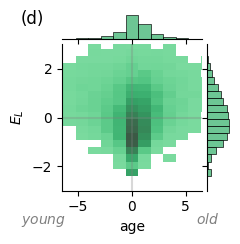

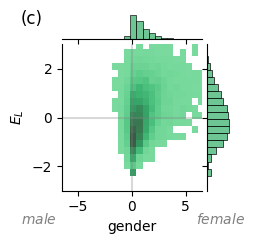

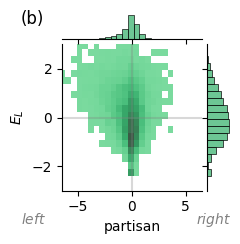

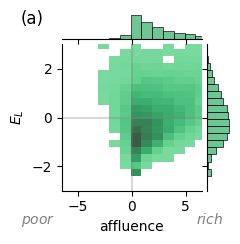

In [243]:
jointplots = []
c = "mediumseagreen"
for j,var in enumerate(sociodemo_users.columns):
    data = sociodemo_users.assign(activity_LT = log_activity_LT[:,3])
    p = sns.jointplot(data = data, x = var, y = "activity_LT", 
                  joint_kws = {"bins": (20, 20)},
                #   gridsize = 15,
                  color = c, height = 2.5, 
                  kind = "hist") 
    # p.ax_marg_y.hist(x = data["activity_LT"], bins = np.arange(-3,3,0.4), color = c)
    # p.ax_marg_x.hist(x = data[var], bins = np.arange(-5,5,0.4), color = c)
# for j,p in enumerate(jointplots):
    p.ax_joint.axhline(0, c = "grey", alpha = 0.3)
    p.ax_joint.axvline(0, c = "grey", alpha = 0.3)
    p.ax_joint.set_xlim(-6.5,6.5)
    p.ax_joint.set_ylim(-3,3)
    p.ax_joint.set_xlabel(var)
    p.ax_joint.set_ylabel("$E_L$")
    # p.fig.tight_layout()
    
    text1, text2 = [["young", "old"], ["male", "female"], ["left", "right"], ["poor", "rich"]][j]
    plt.gcf().text(0.1, 0.1, "$" + text1 + "$", color = "grey")
    plt.gcf().text(0.8, 0.1, "$" + text2 + "$", color = "grey")
    
    plt.gcf().text(0.1, .9, ["(d)", "(c)", "(b)", "(a)"][j], fontsize = 12)

    # p.fig.tight_layout(pad=2)
    # p.fig.show()
    
    jointplots.append(p)
    p.fig.savefig(f"../paper/hist_activity_sociodemo_{var}.pdf", format = "pdf")#, bbox_inches = "tight")



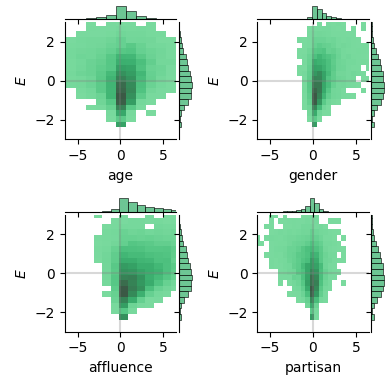

In [113]:
fig = plt.figure(figsize = (4,4))
gs = gridspec.GridSpec(2, 2, top = 20., right = 20.)

mg0 = SeabornFig2Grid(jointplots[0], fig, gs[0])
mg1 = SeabornFig2Grid(jointplots[1], fig, gs[1])
mg2 = SeabornFig2Grid(jointplots[2], fig, gs[3])
mg3 = SeabornFig2Grid(jointplots[3], fig, gs[2])


gs.tight_layout(fig)
# gs.subplots_adjust(hspace=0, wspace=0)
# gs.update(top = 0.7)
# gs.update(right = 0.7)


fig.show()

fig.savefig(f"../paper/hist_activity_sociodemo.pdf", format = "pdf", bbox_inches = "tight")